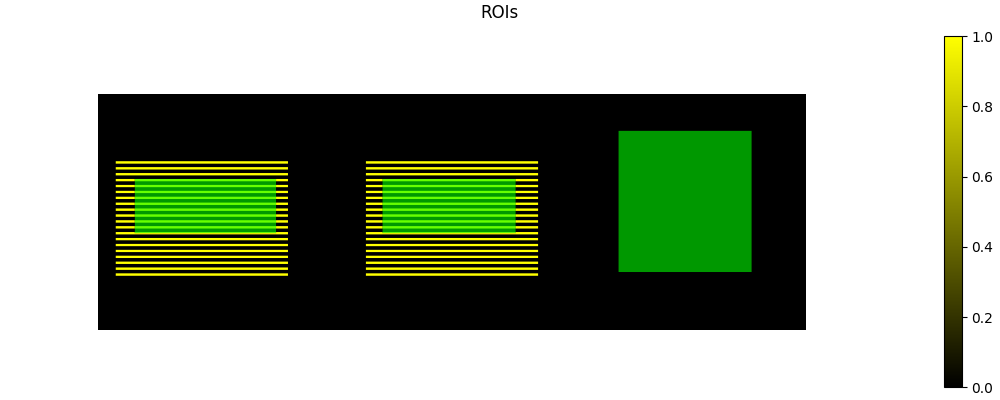

Number of ROIs to shim = 20


In [1]:
%matplotlib widget
import nibabel as nib
import numpy as np
import importlib
from tabulate import tabulate
from pytools import plot
from recotwix.prot_volumes import prot_volumes
from recotwix.sequences import recoB0, recoB1TFLpTx
from pyshim import shimming_base as shim, b0, b1, opt

file_protocol  = '/DATA2/rawdata/pyshim_data//soda/soda2.txt'
work_directory = '/DATA2/rawdata/pyshim_data/temp_nii/'

prot        = prot_volumes(file_protocol)
target_nii  = prot.get('slc')

combined_slc = prot.get('slc').get_combined()
combined_adj = prot.get('adj').get_combined()

plot.plot3D_siemens(combined_slc, combined_adj, cmap=[plot.YELLOW, plot.GREEN_T], alpha=0.6, clim=[[0,1]], title='ROIs')
print(f'Number of ROIs to shim = {len(target_nii)}')

Software version: VD/VE (!?)

Scan  0


100%|██████████| 931M/931M [00:01<00:00, 613MB/s] 


Extracting kspace...
kspace original shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 80, 1, 1, 108, 32, 108]), scantype: image
kspace corrected shape  : torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 80, 1, 1, 108, 32, 110]), scantype: image


k-space to image: 100%|██████████| 32/32 [00:00<00:00, 107.32it/s]


Calculating B0 map. ΔTE = 3500 μs
Masking brain...
[100%] BET: Performing 1000 of 1000 iterations.		
Unwrapping B0...


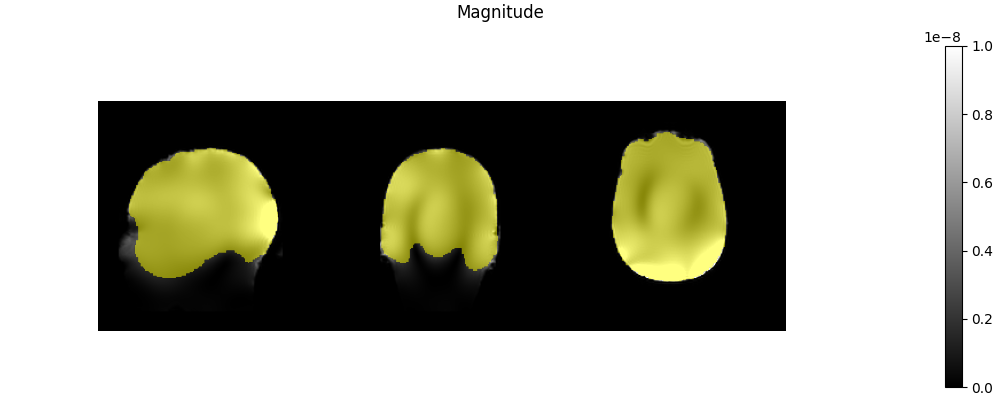

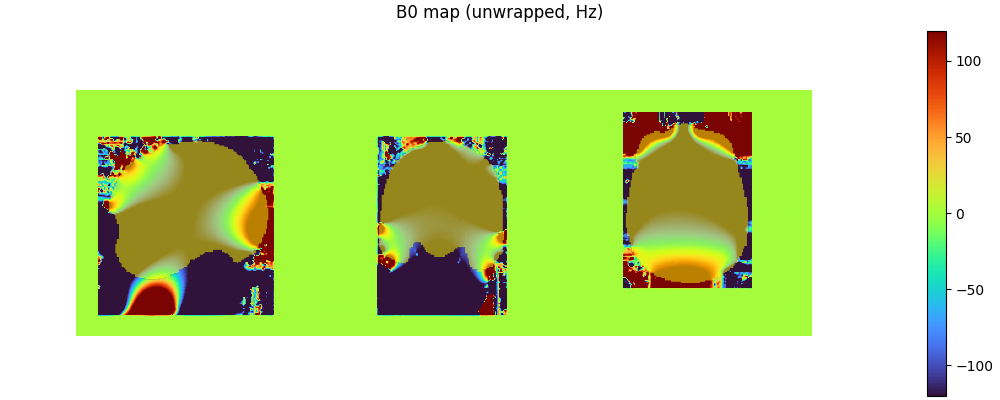

In [2]:
# B0 reconstruction
file_twix_B0   = '/DATA/aaghaeifar/rawdata/B0MapDataSet_7T/M700109/meas_MID00074_FID03504_aa_b0_Sag_WE_2_0mm.dat'
file_twix_B0   = '/DATA2/rawdata/pyshim_data/meas_MID00384_FID06346_B0_map.dat'

b0_obj  = recoB0(file_twix_B0)
mag     = b0_obj.get_mag() ** 0.8
mask    = b0_obj.mask_brain(mag, erode_size=3)

mag_nii  = b0_obj.make_nifti(mag)
mask_nii = b0_obj.make_nifti(mask)
b0_nii   = b0_obj.make_nifti(b0_obj.get_b0hz())

plot.plot3D_siemens(mag_nii, mask_nii, clim=[[0, 1e-8]], cmap=['gray', plot.YELLOW_T], title='Magnitude')
plot.plot3D_siemens(b0_nii, mask_nii, clim=[[-120, 120]], cmap=['turbo', plot.YELLOW_T], title='B0 map (unwrapped, Hz)')

In [3]:
# B0 shimming
importlib.reload(shim)
importlib.reload(b0)

file_basismaps = '/DATA2/rawdata/pyshim_data/meas_MID00047_FID27956_aa_B0Mapping_2ndorder_IECO.nii'
basismaps_nii = nib.load(file_basismaps)
std_affine, std_size = shim.create_standard_space(nifti_target=basismaps_nii)
print(mask_nii.get_data_dtype())
targetr_nii = shim.resample_to_standard_sapce(*target_nii, b0_nii, mask_nii, std_affine=std_affine, std_size=std_size)
b0r_nii     = targetr_nii[-2]
maksr_nii   = targetr_nii[-1]
targetr_nii.pop()
targetr_nii.pop()
ROIs_nii    = [shim.combine_masks(t, maksr_nii) for t in targetr_nii]

up = np.ones(basismaps_nii.shape[-1]) * 30000000
lb = -up
result = b0.calc_b0_shim(basismaps_nii, b0r_nii, ROIs_nii, lb, up)

tl = [[i,j]  for i,j in zip(result['std_initials'], result['std_residuals'])]
tl = tabulate(tl, headers=['std before', 'std after'], floatfmt=('.2f', '.2f'))
print(tl)

float32


resampling to standard space: 100%|██████████| 22/22 [00:00<00:00, 24.43it/s]


  std before    std after
------------  -----------
       13.12         0.61
       65.63        17.40
       81.62        33.75
       88.51        47.28
       91.09        54.72
      111.45        59.09
      143.71        70.63
      190.93        80.66
      190.53        81.88
      144.76        49.72
      119.86        61.19
      130.76        86.11
      132.32        80.95
       94.43        44.43
       72.05        35.17
       48.51        26.03
       59.52        28.02
       87.68        30.29
      103.90        38.22
      105.12        40.24


In [4]:
# B1 reconstruction
file_twix_B1 = '/DATA2/rawdata/twixtools_samples/meas_MID00866_FID61816_db_TFLb1_ICE_48Slc.dat'
file_twix_B1 = '/DATA2/rawdata/pyshim_data/meas_MID00383_FID06345_db_TFLb1_ICE_48Slc.dat'

b1_obj  = recoB1TFLpTx(file_twix_B1)
b1_nii  = b1_obj.make_nifti(b1_obj.img_b1)

# plot.plot3D_siemens(b1_obj.make_nifti(b1_obj.img_cp.abs()), cmap=['turbo'], title='CP')
# plot.plot4D_mosaic(b1_obj.reorder_dims(b1_obj.img_b1.abs()).detach().cpu().numpy(), title='B1+ magnitude')
# plot.plot4D_mosaic(b1_obj.reorder_dims(b1_obj.img_b1.angle()).detach().cpu().numpy(), title='B1+ phase')


Software version: VD/VE (!?)

Scan  0


100%|██████████| 513M/513M [00:01<00:00, 352MB/s] 


Extracting kspace...
kspace original shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 32, 48]), scantype: image
kspace corrected shape  : torch.Size([1, 1, 1, 1, 1, 1, 1, 34, 1, 1, 48, 1, 1, 64, 32, 64]), scantype: image
POCS reconstruction along dim = Col started...
kspace original shape: torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 24, 1, 1, 24, 32, 64]), scantype: refscan
kspace corrected shape  : torch.Size([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 48, 1, 1, 64, 32, 64]), scantype: refscan
Computing coil sensitivity...
Calibration region 32x24x24
Done.
Combining coils... 


k-space to image: 100%|██████████| 32/32 [00:01<00:00, 18.82it/s]


resampling to standard space: 100%|██████████| 22/22 [00:00<00:00, 27.05it/s]


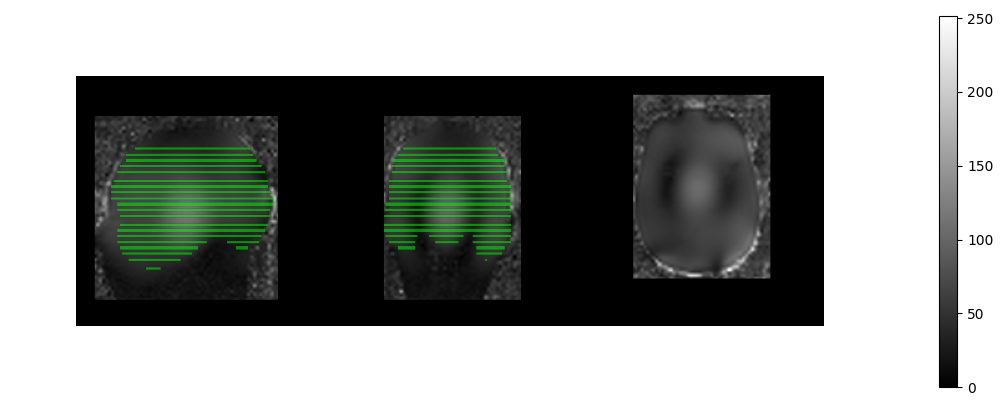

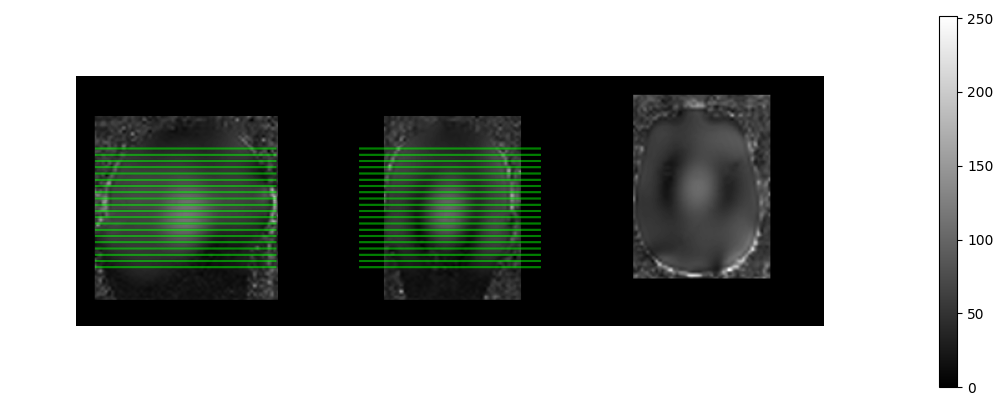

In [5]:
importlib.reload(shim)
# b0_hz.orthoview()
# b0_hz.slicer()

''' we resample to b1, not adj, since b1 is complex and resampling it to another space leads to error originated from b1 wrapped phase '''
std_affine, std_size = shim.create_standard_space(nifti_target=b1_nii)
targetr_nii = shim.resample_to_standard_sapce(*target_nii, b0_nii, mask_nii, std_affine=std_affine, std_size=std_size)
b0r_nii     = targetr_nii[-2]
maksr_nii   = targetr_nii[-1]
targetr_nii.pop()
targetr_nii.pop()
ROIs_nii    = [shim.combine_masks(t, maksr_nii) for t in targetr_nii]

plot.plot3D_siemens(b1_obj.make_nifti(b1_obj.img_cp.abs()), *ROIs_nii, cmap=['gray', plot.GREEN_T])
plot.plot3D_siemens(b1_obj.make_nifti(b1_obj.img_cp.abs()), target_nii.get_combined(), cmap=['gray', plot.GREEN_T])

In [6]:
importlib.reload(b1)
importlib.reload(opt)
importlib.reload(plot)

target_FA = 20
nRF   = 1 # number of subpulses
nTx   = b1_nii.shape[3] # number of transmit channels
rf_len = [1e-3]*nRF
rf_gap = [0]*(nRF-1)

voltages = list()
A = [b1.create_system_matrix(b1_nii, b0r_nii, roi, rf_len=rf_len, rf_gap=rf_gap) for roi in ROIs_nii] # A: list of (nPos x nRF*nTx) matrices
for a in A:
    target = np.ones(a.shape[0], dtype=np.float32) * target_FA / 180 * np.pi
    v, err = opt.mls(a, target)
    # it is very important to bear in mind that in A, col order is: [RF1_Tx1, RF2_Tx1, ..., RFN_Tx1, RF1_Tx2, RF2_Tx2, ..., RFN_Tx2, ...]
    v = v.astype(np.complex64).reshape(nTx, nRF)
    voltages.append(v)

# print(voltages.shape)
# print(np.hstack((np.abs(voltages[5]), np.angle(voltages[5]))))

Loss=78.9: 100%|██████████| 50/50 [00:00<00:00, 729.56it/s]


In [11]:
# Calculate SAR
from scipy.io import loadmat
importlib.reload(b1)
VOPs = loadmat(work_directory + '../RFSWDZZMat9003.bin.mat')['VOPs']
SAR = [b1.calculate_SAR(v, VOPs, rf_len=rf_len, TR=40e-3) for v in voltages]


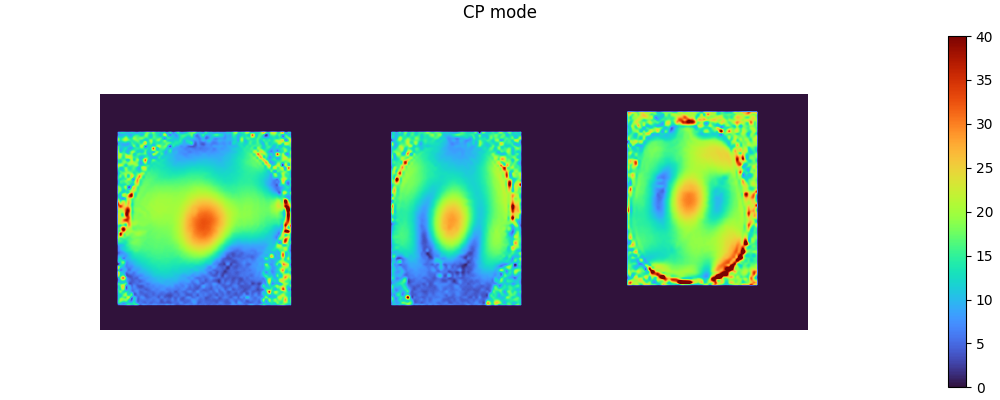

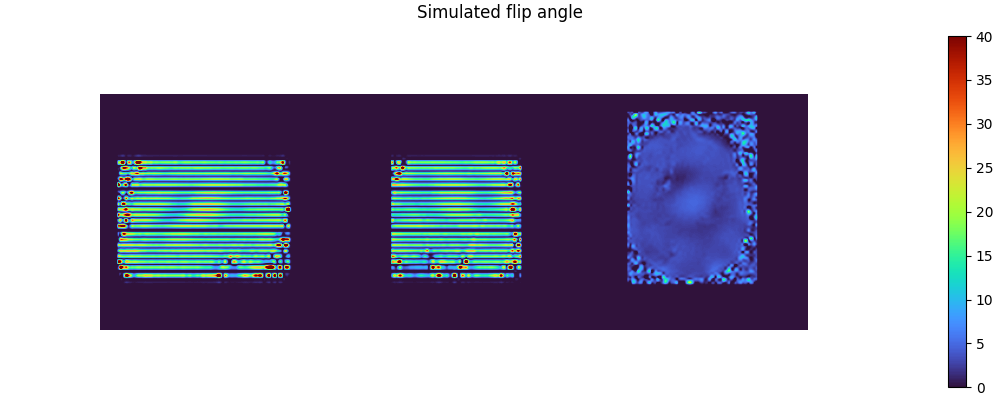

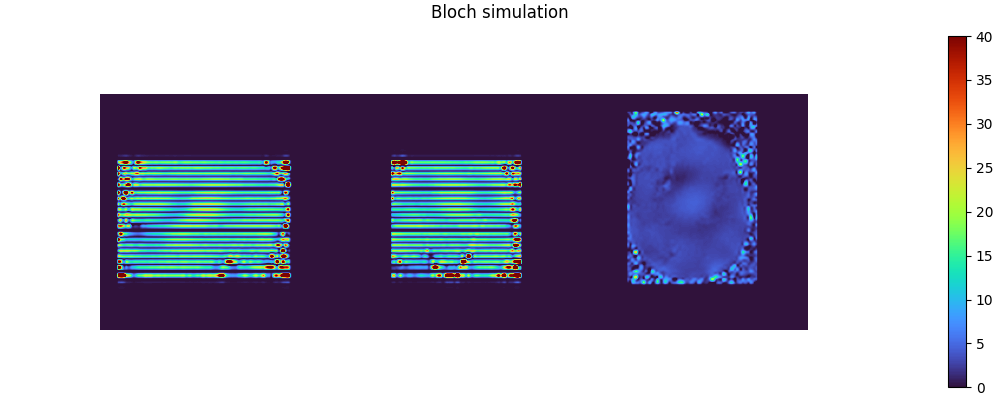

In [8]:
# simulate
importlib.reload(b1)

# CP mode
TraV = b1.calculate_transmit_voltage(b1_obj.prot.ref_voltage, target_FA, normalized_pulse_integral=0.001)
b1_comb_cp = b1.combine_pTx(b1_nii, b1_obj.seqTxScaleFactor.detach().cpu().numpy() * TraV, is_nTv=True) 
FA_cp = shim.scale_nii(b1_comb_cp, b1.gamma*rf_len[0]*180/np.pi)
plot.plot3D_siemens(FA_cp, cmap=['turbo'], clim=[[0.0, 2.0*target_FA]], title='CP mode')

# pTx mode (simulated with system matrix)
# recreate the system matrix but with out brain mask -> easier to visualize the result
A   = [b1.create_system_matrix(b1_nii, b0r_nii, roi, rf_len=rf_len, rf_gap=rf_gap) for roi in targetr_nii]
mxy = [b1.system_matrix_to_mxy(a, v, m) for a, v, m in zip(A, voltages, targetr_nii)]
FA  = [b1.mxy_to_fa(m) for m in mxy]
FA_A  = shim.combine_nii(*FA)
plot.plot3D_siemens(FA_A, cmap=['turbo'], clim=[[0.0, 2.0*target_FA]], title='Simulated flip angle')

# pTx mode (simulated with Bloch simulation)
result = list()
for v, roi in zip(voltages, targetr_nii):
    b1_comb_ptx = b1.combine_pTx(b1_nii, v, is_nTv=True, keep_4th_dim=True) 
    result.append(b1.bloch_simulation(b1_comb_ptx, b0_nii=b0r_nii, mask_nii=roi, rf_len=rf_len, rf_gap=rf_gap))
FA_bloch = shim.combine_nii(*result)
plot.plot3D_siemens(FA_bloch, cmap=['turbo'], clim=[[0.0, 2.0*target_FA]], title='Bloch simulation')


In [12]:
# print voltages and SAR

err_cp          = [shim.calculate_err(FA_cp   , roi, calc_rmse=True, target_rmse=target_FA)[1] for roi in ROIs_nii]
err_pTx_A       = [shim.calculate_err(FA_A    , roi, calc_rmse=True, target_rmse=target_FA)[1] for roi in ROIs_nii]
err_pTx_bloch   = [shim.calculate_err(FA_bloch, roi, calc_rmse=True, target_rmse=target_FA)[1] for roi in ROIs_nii]

tl = [np.abs(v).squeeze().tolist()  for v in voltages]
for i in range(len(tl)):
    tl[i].extend([SAR[i], err_cp[i], err_pTx_A[i], err_pTx_bloch[i]])

tl = tabulate(tl, headers=[f'Tx{i}' for i in range(16)]+['SAR']+['CP']+['A']+['Bloch'] ,floatfmt='.1f')
print(tl)

# print(f'std and rmse (pTx) = {calculate_err(result, mask_combined_nii, calc_rmse=True, target_rmse=target_FA)}')

# b1_comb_ptx_FA = math_img('img1 * img2', img1=b1_comb_ptx, img2=mask_combined_nii)
# b1_comb_ptx_FA = math_img(f'img*{180*b1.gamma*rf_len[0]/np.pi}', img=b1_comb_ptx_FA)
# plot.plot3D_siemens(b1_comb_ptx_FA, cmap=['turbo'], clim=[[0.5*target_FA, 1.8*target_FA]])

  Tx0    Tx1    Tx2    Tx3    Tx4    Tx5    Tx6    Tx7    Tx8    Tx9    Tx10    Tx11    Tx12    Tx13    Tx14    Tx15    SAR    CP    A    Bloch
-----  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------  ------  ------  ------  ------  ------  -----  ----  ---  -------
 44.9   75.1   55.6   24.3   55.4    5.4   22.6   10.2   41.6   12.3    62.3    20.9    28.4    14.5    13.4    13.5   34.4   9.0  0.4      0.0
 29.4   25.2   21.7   18.5   17.6   10.2   18.3   25.6   16.0   11.9    25.2     5.8    20.7    10.0    10.5     9.7    6.4   8.4  0.8      1.0
 33.4   12.1   41.6   14.7    3.8    4.9   14.9   14.5   11.9   21.2    28.6    14.9    28.3    23.4    27.9    12.7    9.9   8.5  1.2      1.5
 32.8   18.1   16.2   14.5   13.4    7.1    8.6    3.0   16.3   16.0    11.4     9.5    16.6    16.9    14.5    15.3    5.1   8.3  1.6      1.8
 31.3   11.3   16.7   11.4    4.4    8.2   20.5   18.5   11.4    8.7    10.9    12.0    15.0     6.0    30.6    11.8    5.5   8.1  2.1  

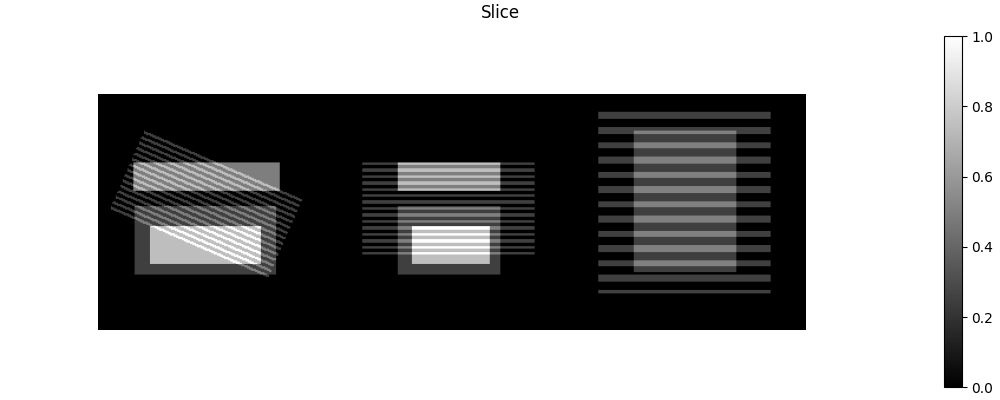

In [10]:
%matplotlib widget
from recotwix.prot_volumes import prot_volumes
from pytools import plot

file_protocol  = '/DATA2/rawdata/pyshim_data/soda/soda4_pTx.txt'

prot = prot_volumes(file_protocol)
combined_slc = prot.get('slc').get_combined()
combined_adj = prot.get('adj')[0]
combined_pTx = prot.get('ptx').get_combined()

plot.plot3D_siemens(combined_slc, combined_adj, combined_pTx, cmap='gray', title='Slice')
